
# Sentiment Analysis


## 1) Load & Combine Data

In [16]:

# Load Data
import pandas as pd

df_yelp = pd.read_csv('./sentiment labelled sentences/yelp_labelled.txt', names=['sentence', 'label'], sep='\t')
df_amazon = pd.read_csv('./sentiment labelled sentences/amazon_cells_labelled.txt', names=['sentence', 'label'], sep='\t')
df_imdb = pd.read_csv('./sentiment labelled sentences/imdb_labelled.txt', names=['sentence', 'label'], sep='\t')

print("Yelp: ", df_yelp.shape)
print("Amazon: ", df_amazon.shape)
print("IMDB: ", df_imdb.shape)

df_all = pd.concat([df_yelp, df_amazon, df_imdb], ignore_index=True)
print("All: ", df_all.shape)
df_all.head()


Yelp:  (1000, 2)
Amazon:  (1000, 2)
IMDB:  (748, 2)
All:  (2748, 2)


,sentence,label
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


## 2) Explore Data

In [17]:

# Explore Data
import re, numpy as np, pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Dataset-wise label distribution (%)
for name, d in [('Yelp', df_yelp), ('Amazon', df_amazon), ('IMDB', df_imdb)]:
    percent = d['label'].value_counts(normalize=True, dropna=False).sort_index() * 100
    print(f"{name} Verteilung (%):\n", percent.round(2), "\n")

df = df_all.copy()

# Tokenizer (keeps simple English words and contractions like don't)
_token_re = re.compile(r"[A-Za-z]+(?:'[A-Za-z]+)?")
def tok(s): 
    if not isinstance(s, str): return []
    return _token_re.findall(s.lower())

# Grundüberblick
print("Shape:", df.shape)
print("Missing:", df.isna().sum().to_dict())
print("\nLabel-Verteilung (Count/%)")
counts = df['label'].value_counts().sort_index()
pct = (df['label'].value_counts(normalize=True).sort_index()*100).round(2)
display(pd.DataFrame({'count': counts, 'percent': pct}))

# Kern-Metriken je Text
def stats(text):
    s = text if isinstance(text, str) else ""
    t = tok(s)
    n = len(t)
    return pd.Series({
        'char_len': len(s),
        'word_len': n,
        'avg_word_len': (sum(len(x) for x in t)/n) if n else 0.0,
        'stop_ratio': (sum(x in ENGLISH_STOP_WORDS for x in t)/(n or 1)),
        'ttr': (len(set(t))/(n or 1)),
    })

fe = df['sentence'].apply(stats)
df_e = pd.concat([df[['label']], fe], axis=1)

print("\nGesamt-Deskriptoren:")
display(df_e.describe().round(3).T)

print("\nMittelwerte je Label:")
display(df_e.groupby('label').mean(numeric_only=True).round(3))

# N-Grams (Top 10)
def top_ngrams(texts, n=1, k=10, drop_stop=True):
    c = Counter()
    for s in texts:
        t = tok(s)
        if drop_stop: t = [w for w in t if w not in ENGLISH_STOP_WORDS]
        grams = t if n==1 else [" ".join(t[i:i+n]) for i in range(len(t)-n+1)]
        c.update(grams)
    return pd.DataFrame(c.most_common(k), columns=[f'{n}-gram','count'])

print("\nTop Unigrams (gesamt):")
display(top_ngrams(df['sentence'], n=1, k=10))

print("\nTop Bigrams (gesamt):")
display(top_ngrams(df['sentence'], n=2, k=10))

for lbl in sorted(df['label'].unique()):
    subset = df.loc[df['label']==lbl, 'sentence']
    print(f"\nTop Unigrams (Label={lbl}):")
    display(top_ngrams(subset, n=1, k=10))
    print(f"\nTop Bigrams (Label={lbl}):")
    display(top_ngrams(subset, n=2, k=10))

# Vokabulargröße (ohne Stopwords)
def vocab_size(texts):
    v=set()
    for s in texts: v.update([w for w in tok(s) if w not in ENGLISH_STOP_WORDS])
    return len(v)

print("\nVokabular gesamt (ohne Stopwords):", vocab_size(df['sentence']))
print("Vokabular je Label (ohne Stopwords):")
display(df.groupby('label')['sentence'].apply(vocab_size).to_frame('vocab_size'))


Yelp Verteilung (%):
 label
0    50.0
1    50.0
Name: proportion, dtype: float64 

Amazon Verteilung (%):
 label
0    50.0
1    50.0
Name: proportion, dtype: float64 

IMDB Verteilung (%):
 label
0    48.4
1    51.6
Name: proportion, dtype: float64 

Shape: (2748, 2)
Missing: {'sentence': 0, 'label': 0}

Label-Verteilung (Count/%)


,count,percent
label,,
0,1362,49.56
1,1386,50.44



Gesamt-Deskriptoren:


,count,mean,std,min,25%,50%,75%,max
label,2748.0,0.504,0.500,0.0,0.000,1.000,1.000,1.0
char_len,2748.0,71.528,201.987,7.0,32.000,55.000,87.000,7944.0
word_len,2748.0,12.896,33.489,0.0,6.000,10.000,16.000,1297.0
avg_word_len,2748.0,4.498,0.974,0.0,3.923,4.364,4.909,13.0
stop_ratio,2748.0,0.494,0.181,0.0,0.417,0.500,0.609,1.0
ttr,2748.0,0.956,0.073,0.0,0.917,1.000,1.000,1.0



Mittelwerte je Label:


,char_len,word_len,avg_word_len,stop_ratio,ttr
label,,,,,
0,74.302,13.467,4.462,0.515,0.955
1,68.802,12.334,4.533,0.474,0.956



Top Unigrams (gesamt):


,1-gram,count
0,good,231
1,great,210
2,movie,181
3,phone,165
4,film,160
5,food,126
6,like,125
7,just,119
8,place,114
9,it's,114



Top Bigrams (gesamt):


,2-gram,count
0,waste time,17
1,works great,17
2,customer service,15
3,sound quality,14
4,waste money,12
5,don't waste,11
6,highly recommend,11
7,battery life,11
8,don't think,10
9,i've seen,10



Top Unigrams (Label=0):


,1-gram,count
0,bad,96
1,movie,95
2,phone,78
3,film,71
4,just,69
5,like,67
6,food,66
7,time,62
8,don't,60
9,good,57



Top Bigrams (Label=0):


,2-gram,count
0,waste time,16
1,customer service,12
2,waste money,12
3,don't waste,11
4,don't think,8
5,i've seen,8
6,it's just,6
7,doesn't work,6
8,does work,6
9,don't buy,6



Top Unigrams (Label=1):


,1-gram,count
0,great,193
1,good,174
2,film,89
3,phone,87
4,movie,86
5,food,60
6,really,60
7,it's,60
8,best,59
9,place,58



Top Bigrams (Label=1):


,2-gram,count
0,works great,17
1,highly recommend,11
2,sound quality,10
3,great phone,9
4,great food,8
5,really good,8
6,great service,7
7,pretty good,7
8,food good,7
9,good quality,7



Vokabular gesamt (ohne Stopwords): 4903
Vokabular je Label (ohne Stopwords):


,vocab_size
label,
0,3111
1,3079


## 3) Text Cleaning

In [18]:

import re
import html
from html import unescape
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Optional: NLTK for lemmatization with safe fallback to stemming
use_lemmatize = True
try:
    import nltk
    from nltk.stem import WordNetLemmatizer
    nltk.data.find('corpora/wordnet')
    nltk.data.find('corpora/omw-1.4')
    _lemmatizer = WordNetLemmatizer()
except Exception:
    use_lemmatize = False

from nltk.stem import PorterStemmer
_stemmer = PorterStemmer()

# Basic contraction map (extend as needed)
CONTRACTIONS = {
    "ain't":"am not", "aren't":"are not", "can't":"cannot", "can't've":"cannot have",
    "could've":"could have", "couldn't":"could not", "didn't":"did not", "doesn't":"does not",
    "don't":"do not", "hadn't":"had not", "hasn't":"has not", "haven't":"have not",
    "he's":"he is", "she's":"she is", "it's":"it is", "i'm":"i am", "i've":"i have",
    "i'd":"i would", "i'll":"i will", "isn't":"is not", "let's":"let us", "mightn't":"might not",
    "mustn't":"must not", "shan't":"shall not", "shouldn't":"should not",
    "that's":"that is", "there's":"there is", "they're":"they are", "they've":"they have",
    "we're":"we are", "we've":"we have", "we'll":"we will", "weren't":"were not",
    "what's":"what is", "who's":"who is", "won't":"will not", "wouldn't":"would not",
    "you'd":"you would", "you'll":"you will", "you're":"you are", "y'all":"you all"
}

_url_re = re.compile(r"https?://\S+|www\.\S+", re.IGNORECASE)
_html_tag_re = re.compile(r"<[^>]+>")
_num_re = re.compile(r"\b\d+(?:[.,]\d+)?\b")
_punct_re = re.compile(r"[\.,!?:;\-\(\)\[\]\{\}\"\'`~\/_\\\|@#\$%\^&\*\+=><]+" )
_token_re = re.compile(r"[A-Za-z]+(?:'[A-Za-z]+)?")

def expand_contractions(text: str) -> str:
    def repl(match):
        c = match.group(0)
        return CONTRACTIONS.get(c.lower(), c)
    return re.sub(r"\b(" + "|".join(map(re.escape, CONTRACTIONS.keys())) + r")\b", repl, text, flags=re.IGNORECASE)

def basic_clean(text: str) -> str:
    if not isinstance(text, str):
        return ""
    s = html.unescape(text)
    s = _url_re.sub(" ", s)                 # remove URLs
    s = _html_tag_re.sub(" ", s)            # remove HTML tags
    s = expand_contractions(s)              # expand contractions
    s = _num_re.sub(" ", s)                 # remove numbers
    s = _punct_re.sub(" ", s)               # remove punctuation
    s = s.lower()
    s = re.sub(r"\s+", " ", s).strip()
    return s

def tokenize(text: str):
    return _token_re.findall(text)

def remove_stopwords(tokens, stopwords=ENGLISH_STOP_WORDS):
    return [t for t in tokens if t not in stopwords]

def normalize_tokens(tokens):
    out = []
    for t in tokens:
        if use_lemmatize:
            try:
                out.append(_lemmatizer.lemmatize(t))
            except Exception:
                out.append(_stemmer.stem(t))
        else:
            out.append(_stemmer.stem(t))
    return out

def clean_and_tokenize(text: str):
    s = basic_clean(text)
    toks = tokenize(s)
    toks = remove_stopwords(toks)
    toks = normalize_tokens(toks)
    return s, toks

# Apply cleaning
df['clean_text'], df['tokens'] = zip(*df['sentence'].map(clean_and_tokenize))

# Sentence lengths after cleaning (in tokens)
df['len_tokens'] = df['tokens'].apply(len)
df[['sentence','clean_text','label','len_tokens']].head()


,sentence,clean_text,label,len_tokens
0,Wow... Loved this place.,wow loved this place,1,3
1,Crust is not good.,crust is not good,0,2
2,Not tasty and the texture was just nasty.,not tasty and the texture was just nasty,0,4
3,Stopped by during the late May bank holiday of...,stopped by during the late may bank holiday of...,1,8
4,The selection on the menu was great and so wer...,the selection on the menu was great and so wer...,1,4


## 4) Exploratory Data Analysis (EDA)

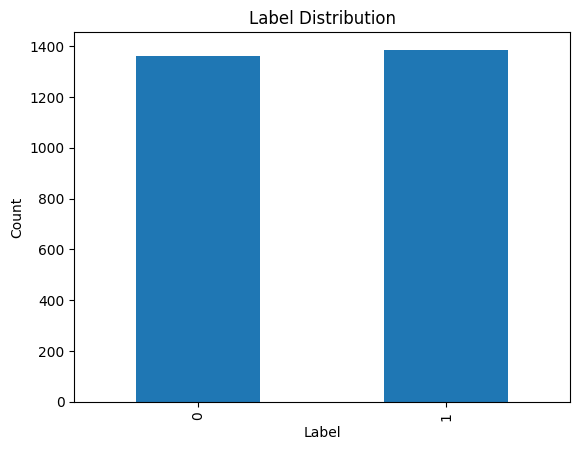

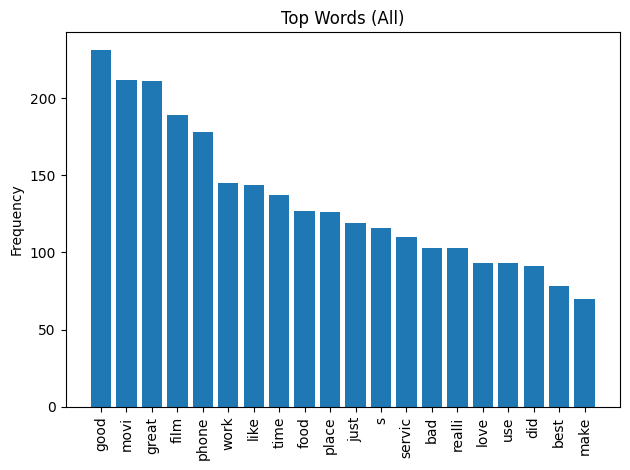

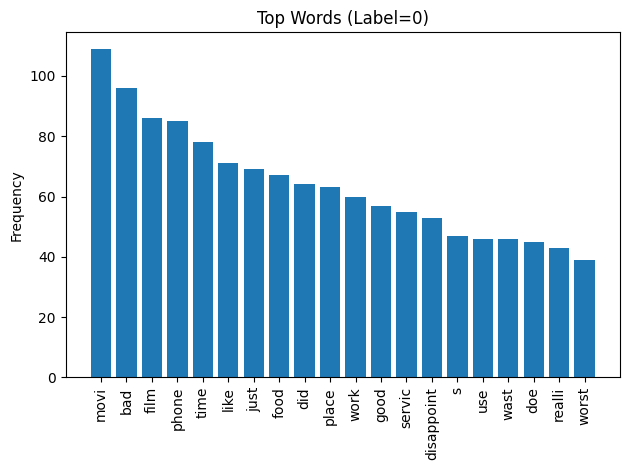

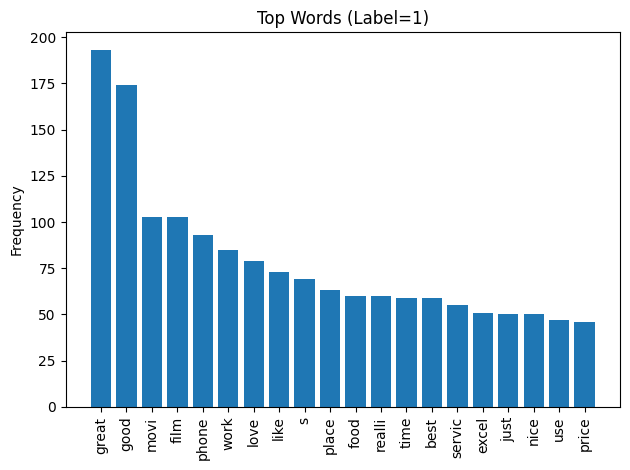

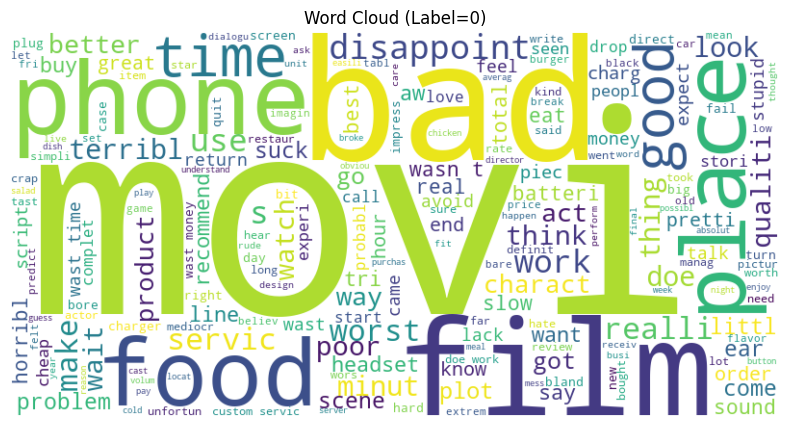

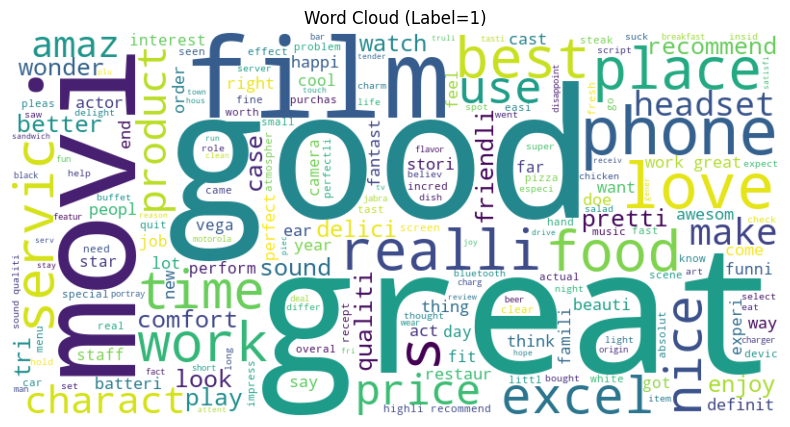

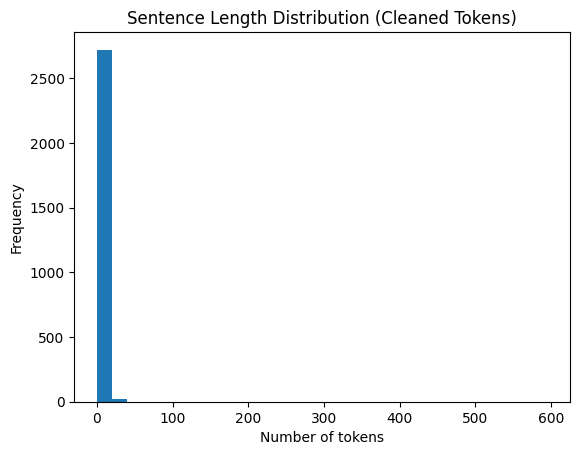

In [ ]:

import matplotlib.pyplot as plt
from collections import Counter

# Label distribution (bar chart)
label_counts = df['label'].value_counts().sort_index()
plt.figure()
label_counts.plot(kind='bar')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Word frequency plots (top 20 global, and per class top 20)
def plot_top_words(token_series, title, top_k=20):
    freq = Counter([t for tokens in token_series for t in tokens])
    top = freq.most_common(top_k)
    words, counts = zip(*top) if top else ([], [])
    plt.figure()
    plt.bar(range(len(words)), counts)
    plt.xticks(range(len(words)), words, rotation=90)
    plt.title(title)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

plot_top_words(df['tokens'], 'Top Words (All)', top_k=20)

for lbl in sorted(df['label'].unique()):
    plot_top_words(df.loc[df['label']==lbl, 'tokens'], f'Top Words (Label={lbl})', top_k=20)

# Word cloud for each class
try:
    from wordcloud import WordCloud
    for lbl in sorted(df['label'].unique()):
        text_blob = " ".join([" ".join(toks) for toks in df.loc[df['label']==lbl, 'tokens']])
        if text_blob.strip():
            wc = WordCloud(width=800, height=400, background_color='white').generate(text_blob)
            plt.figure(figsize=(10,5))
            plt.imshow(wc, interpolation='bilinear')
            plt.axis('off')
            plt.title(f'Word Cloud (Label={lbl})')
            plt.show()
        else:
            print(f"No tokens for label {lbl} to build word cloud.")
except Exception as e:
    print("WordCloud not available:", e)

# Sentence length distribution (histogram over cleaned token lengths)
plt.figure()
df['len_tokens'].plot(kind='hist', bins=30)
plt.title('Sentence Length Distribution (Cleaned Tokens)')
plt.xlabel('Number of tokens')
plt.ylabel('Frequency')
plt.show()


## 5) Train/Validation/Test Split (70/15/15)

In [20]:

from sklearn.model_selection import train_test_split

X = df[['sentence','clean_text','tokens']].copy()
y = df['label'].astype(int)

# First: Train (70%) vs Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Second: Validation (15%) vs Test (15%) by splitting temp in half
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Shapes:")
print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)

print("Saved: train_split.csv, val_split.csv, test_split.csv")


Shapes:
Train: (1923, 3) (1923,)
Val:   (412, 3) (412,)
Test:  (413, 3) (413,)
Saved: train_split.csv, val_split.csv, test_split.csv
